<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для интернет-магазина «Викишоп»

**Проект:  Проект для интернет-магазина «Викишоп»**
_____
**Описание исследования.**
    
К нам обратился интернет-магазин «Викишоп», который запускает новый сервис для того, чтобы пользователи могли редактировать и дополнять описания товаров, как в вики-сообществах. Клиенты будут предлагать свои правки и комментировать изменения других. Заказчику нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 
_____
**Цель исследования.**
    
Построить модель для оценки тональности текста для полной или частичной автоматизации модерации.
    
_____
**Задачи исследования.**

Для того, чтобы достичь поставленной цели необходимо решить ряд задач:

- подготовить данные, которые нам предоставил заказчик;
- провести анализ полученных данных (проверить данные на наличие ошибок, найти закономерности);
- построить модель, качество которой будет удовлетворять требованиям заказчика;
- протестировать полученную модель на тестовой выборке и сделать выводы.
_____\
**Исходные данные.**
    
Заказчиком были переданы данные в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [14]:
#!pip install imbalanced-learn -q
#!pip install wordcloud
#!pip install swifter - q
#!pip install xgboost
#!pip install urlextract

In [15]:
import pandas as pd
from tqdm import notebook
import re
from time import time 
import torch
import swifter
import transformers
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import numpy as np
from numpy.random import default_rng
import transformers
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, classification_report, make_scorer
from __future__ import unicode_literals, print_function
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import FixedThresholdClassifier, TunedThresholdClassifierCV
from sklearn.feature_extraction.text import CountVectorizer

In [16]:
from urlextract import URLExtract

In [18]:
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\igor.grenaderov\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\igor.grenaderov\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
pd.set_option('display.max_colwidth', None)

In [20]:
RANDOM_STATE = 88

## Подготовка

In [21]:
url = 'https://code.s3.yandex.net/datasets/toxic_comments.csv'

In [22]:
df = pd.read_csv(url)

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>Комментарий</b></u></font>
    <br />
    <font color='4682B4'>

Импортировал данные `toxic_comments.csv` с исходными данными.

</font></div>

In [23]:
df.head()

,Unnamed: 0,text,toxic
0,0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,4,"You, sir, are my hero. Any chance you remember what page that's on?",0


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>Комментарий</b></u></font>
    <br />
    <font color='4682B4'>

Вывел информацию о полученном датафрейме: типы данных корректные, пропусков нет.

</font></div>

In [12]:
df.drop('Unnamed: 0', axis=1, inplace=True)

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>Комментарий</b></u></font>
    <br />
    <font color='4682B4'>

Удалил столбец `Unnamed: 0`.

</font></div>

In [13]:
df['text'].duplicated().sum()

0

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>Комментарий</b></u></font>
    <br />
    <font color='4682B4'>

Проверил, есть ли в данных явные дубликаты - явных дубликатов не обнаружил.

</font></div>

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [80]:
def nl_split(string):
    
    string = re.split('\n+',string)
    result = [sent_tokenize(i.strip()) for i in string]
    result = sum(result, [])
    
    return [i for i in result if len(i)>1]

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>Комментарий</b></u></font>
    <br />
    <font color='4682B4'>

Написал функцию для разделения строк на предложения.

</font></div>

In [81]:
df['sents_len'] = df['text'].swifter.apply(lambda x: len(nl_split(x)))

Pandas Apply:   0%|          | 0/159292 [00:00<?, ?it/s]

In [82]:
df['len'] = df['text'].swifter.apply(lambda x: len(x))

Pandas Apply:   0%|          | 0/159292 [00:00<?, ?it/s]

In [96]:
df['word_count'] = df['text'].swifter.apply(lambda x: len(word_tokenize(x)))

Pandas Apply:   0%|          | 0/159292 [00:00<?, ?it/s]

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>Комментарий</b></u></font>
    <br />
    <font color='4682B4'>

Добавил столбцы с длинной текста, количеством слов (которые встречаются в словаре nltk) и количеством предложений.

</font></div>

In [131]:
def distribution_plt(df_list, name, val_list, plt_xlim=1):

    x_max = min([series.max() for series in df_list])* plt_xlim

    fig, ax = plt.subplots(2,1,figsize=(10,8))
    ax[0].boxplot([df for df in df_list], vert=False)

    ax[0].set_yticklabels(val_list)
    ax[0].set_xlabel(name)
    ax[0].set_xlim([0, x_max])

    ax[1].hist([df for df in df_list], histtype='stepfilled', bins=500)
    ax[1].set_ylabel('частота')
    ax[1].set_xlabel(name)
    ax[1].set_xlim([0, x_max])
    ax[1].legend(val_list[::-1]);
    
    plt.suptitle(f'Ящики с усами и гистограмма для признака "{name}"')
    

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>Комментарий</b></u></font>
    <br />
    <font color='4682B4'>

Написал функцию для построения графиков с целью оценки распределения количественных значений для токсичных и не токсичных комментариев.
        
</font></div>

In [104]:
name_dict = {'word_count' : 'количество слов',
 'sents_len' : 'количество предложений',
 'len' : 'количество символов'}

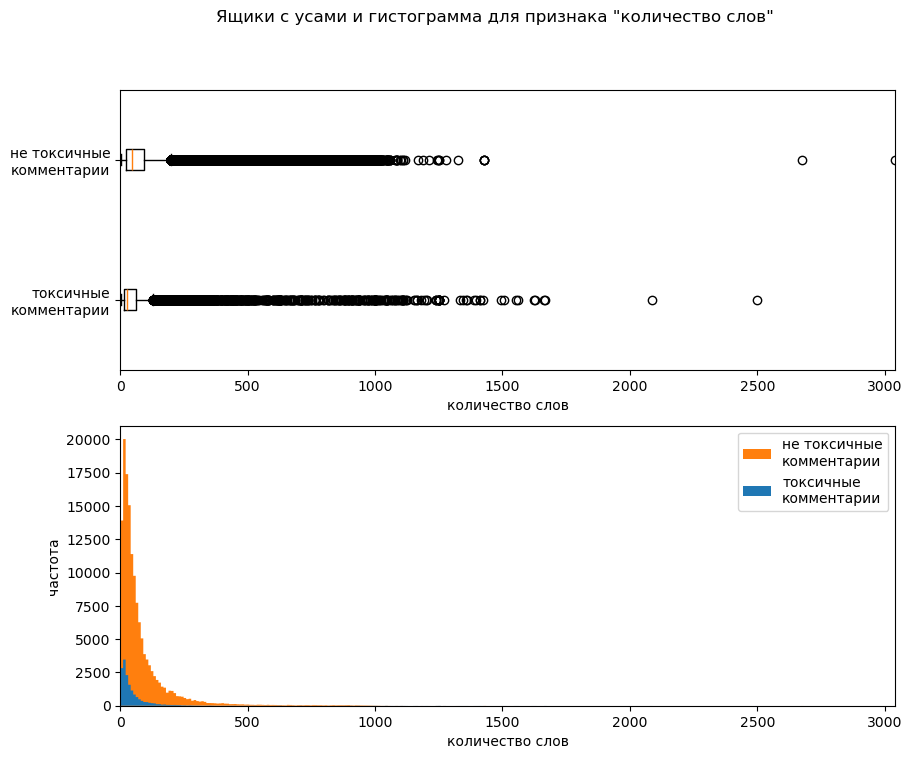

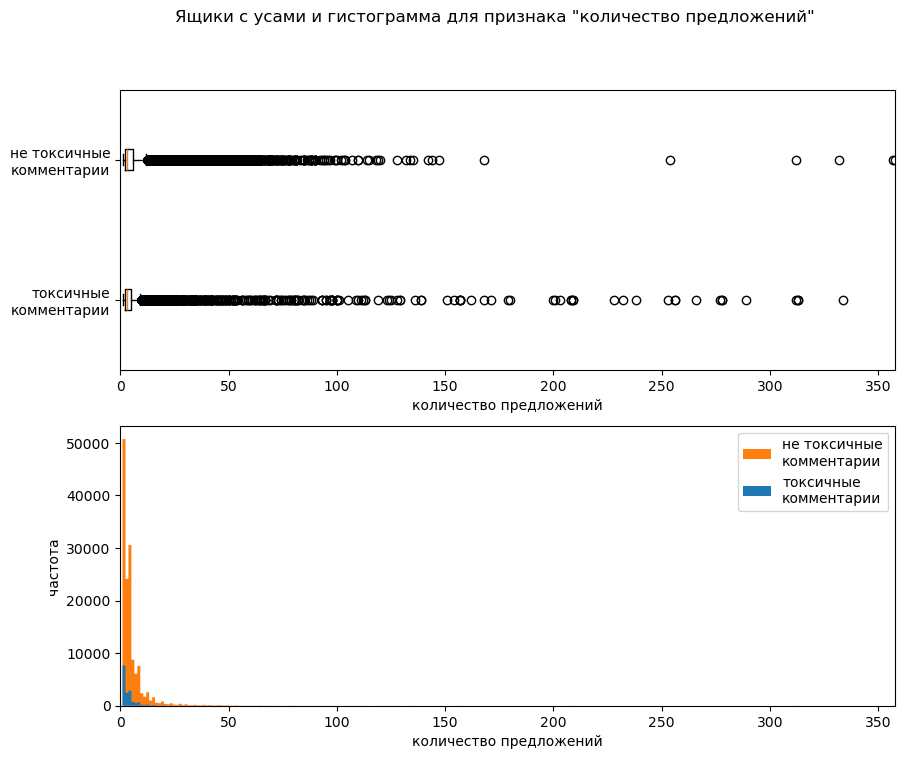

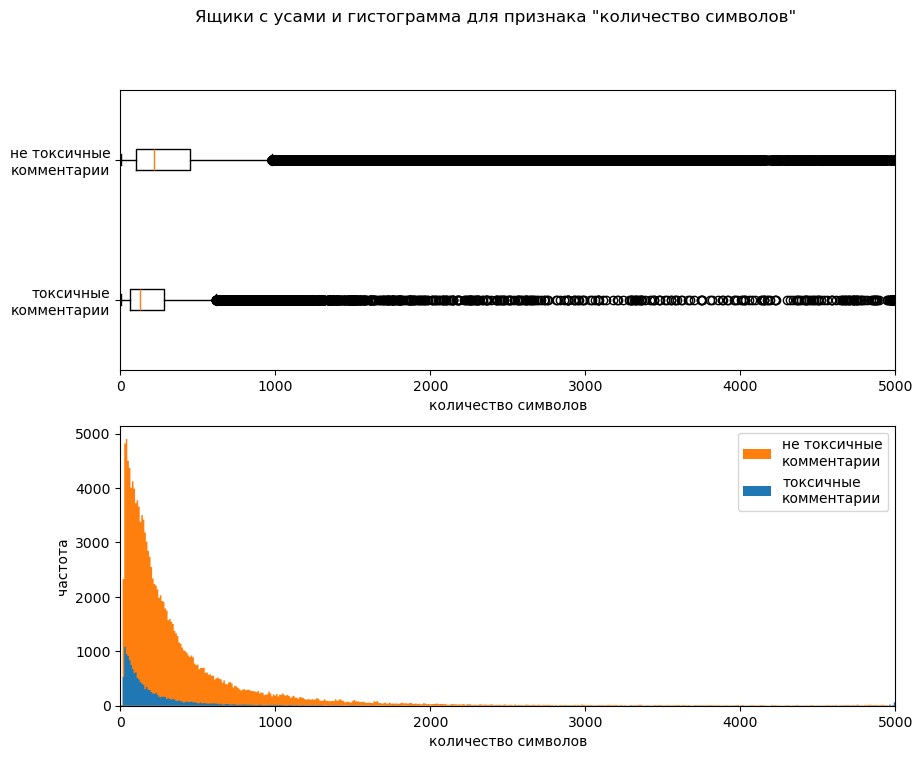

In [132]:
for col in ['word_count', 'sents_len', 'len']:
    
    distribution_plt(
        
        [df[df['toxic']==1][col], df[df['toxic']==0][col]],
        
        name_dict[col],
        
        ['токсичные\nкомментарии', 'не токсичные\nкомментарии'],
        
        1)

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>Комментарий</b></u></font>
    <br />
    <font color='4682B4'>

Построил графики на которых отобразил распределения для токсичных и не токсичных комментариев. Видно, что аномально большие значения встречаются в обеих категориях комментариев.
        
</font></div>

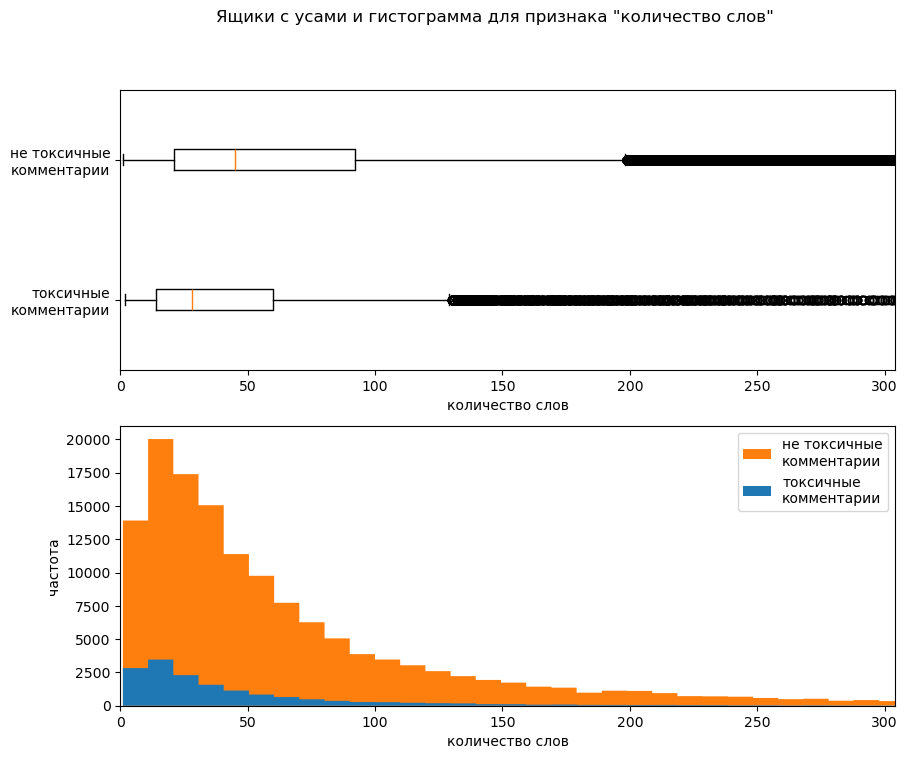

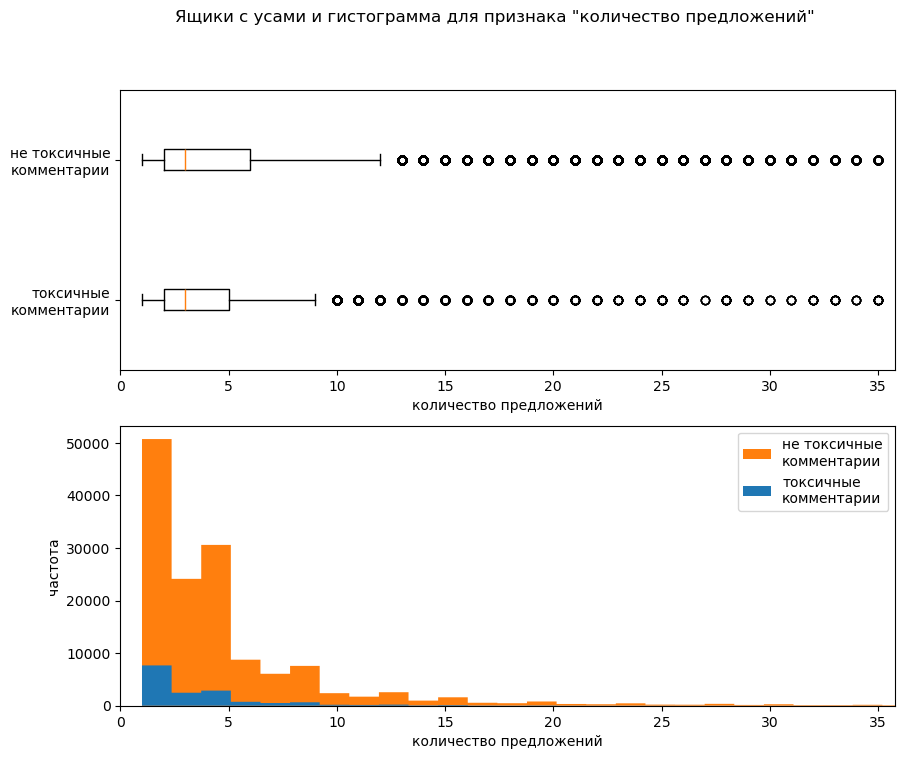

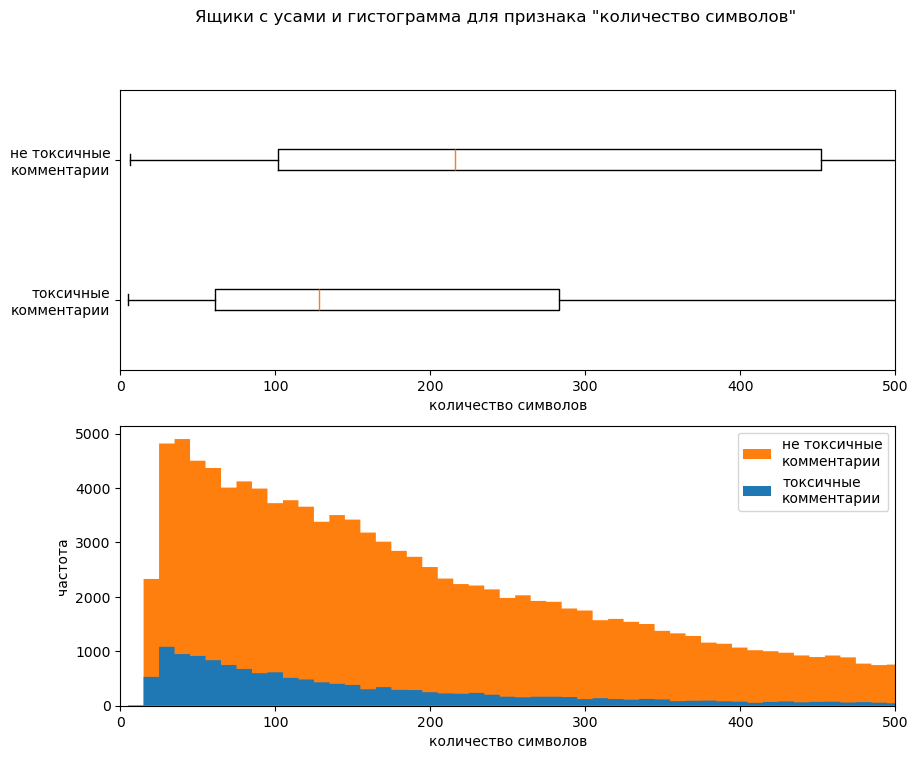

In [133]:
for col in ['word_count', 'sents_len', 'len']:
    
    distribution_plt(
        
        [df[df['toxic']==1][col], df[df['toxic']==0][col]],
        
        name_dict[col],
        
        ['токсичные\nкомментарии', 'не токсичные\nкомментарии'],
        
        0.1)

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>Комментарий</b></u></font>
    <br />
    <font color='4682B4'>

Построил графики с лимитом для того, чтобы проще было изучить данные. Теперь можно увидеть, что:
* медианы у и квартили токсичных и не токсичных комментариев отличаются;
* не токсичные комментарии, как правило, содержат большее количество предложений, символов и слов.
        
</font></div>

In [ ]:
df.info()

In [59]:
def w_count(dataframe, df_cleaning=False, stop_words_filtered = False):

    if df_cleaning == True:
        dataframe = dataframe.str.lower()
        display('text lowered')
        dataframe = dataframe.swifter.apply(lambda x: re.sub(r'\W', ' ', x))
        display('only words in text ')
        dataframe = dataframe.swifter.apply(lambda x: re.sub(r'\s+', ' ', x))
        display('text is striped')
        
    
    word2count = {}
    
    for data in dataframe:
        words = nltk.word_tokenize(data)
        for word in words:
            if word not in word2count:
                word2count[word] = 1
            else:
                word2count[word] += 1

    if stop_words_filtered == True:
        display('stop words are removed')
        stop_words = set(stopwords.words('english'))
        filtered_word2count = {word: count for word, count in word2count.items() if word not in stop_words}
        word_freq_df = pd.DataFrame(list(filtered_word2count.items()), columns=['Word', 'Frequency'])
        word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False)
    else:
        filtered_word2count = {word: count for word, count in word2count.items()}
        word_freq_df = pd.DataFrame(list(filtered_word2count.items()), columns=['Word', 'Frequency'])
        word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False)

    return word_freq_df

In [17]:
######################################################################################

In [ ]:
df['text']

In [149]:
df['text'][50961]

'@Brit guy... good one. The comment was not a generalization for all brits. I speak English and you can very well understand that I respect the Queen and all but the loser who think that a guy with darker skin can easily be a target need to review their thinking and meet a shrink to clean their messed up inferiority-complex filled sub-conscious ) and being a bipedal you ought to learn to sign your name after edits )'

In [154]:
tokenizer.decode(chunker('I Hate YOU!!!'))

'[CLS] [UNK] [UNK] [UNK]!!! [SEP]'

In [18]:
#df[df['len']>2500]['text'].sample()

In [19]:
#print(' '.join([clean_text(i) for i in nl_split(df['text'][3536])]))

In [20]:
#print(clean_text(df['text'][4581]))

In [21]:
#nl_split(df['text'][152428])

In [22]:
#nl_split(df['text'][4581])

In [30]:
#clean_sents(df['text'][10])

In [18]:
#url_rem(df['text'][149325])

In [19]:
#[url_rem(sen) for sen in nl_split(df['text'][149325])]

In [21]:
#clean_sents(df['text'][149325])

In [643]:
#clean_sents(df['text'][80726])

In [171]:
def url_rem(string_):
    extractor = URLExtract()
    urls = extractor.find_urls(string_)
    for url in urls:
        string_ = re.sub(re.escape(url), ' XXLNK ', string_)
    
    string_ = re.sub(r'https?://\S+|www\.\S+', ' XXLNK ', string_)
    string_ = re.sub(r'<.*?>+', ' XXLNK ', string_)
    return string_

In [172]:
def mail_user_rem(string_):
    
    string_ = re.sub(r'[A-Za-z0-9\_]*@[A-Za-z]*\.?[A-Za-z0-9]*', ' XXM ', string_)
    string_ = re.sub(r'User:\S+', ' XXU ', string_)

    return string_

def nl_split(string):
    
    string = re.split('\n+',string)
    result = [sent_tokenize(i.strip()) for i in string]
    result = sum(result, [])
    
    return [i for i in result if len(i)>1]

In [174]:
def brackets(string, symbol, symbol1):

    '''symbol - [ or { ; symbol1 - ] or } '''
    
    patt = '\\' + symbol + '+' + '|' + '\\' + symbol1 + '+'
     
    init_string = string
    
    braks = re.findall(patt, string)
    
    if len(braks)>1:

        
        
        if braks[0]==symbol1 or braks[0]==symbol1*2:
            patt1 = '\\' + symbol1 + '+'
            string =  re.split(patt1, string, maxsplit = 1)[::-1]+[symbol1]
                
            string = ' '.join(string)
            
        
        sub_patt = '\\' + symbol + '+' + '.*' + '\\' + symbol1 + '+'
            
        result = re.sub(sub_patt, ' XXBRCT ', string)        
        
    else:
        result = string
        
    return result

In [404]:
def clean_text(string):

    flag = re.IGNORECASE
    
    string = re.sub(r'\S+.png',' XXF ', string, flags=flag)
    string = re.sub(r'\S+.jpeg',' XXF ', string, flags=flag)
    string = re.sub(r'\S+.jpg',' XXF ', string, flags=flag)
    string = re.sub(r'\S+.gif',' XXF ', string, flags=flag)
    string = re.sub(r'\S+.pdf',' XXF ', string, flags=flag)
    string = re.sub(r'\S+#\S+',' XXH ', string)
    
    string = re.sub(r'Image:\S+', ' XXF ', string, flags=flag)
    string = re.sub(r'File:\S+', ' XXF ', string, flags=flag)
    string = re.sub(r'Category:\S*',' XXC ',string, flags=flag)
    string = re.sub(r'Talk:\S+|User_talk:\S+',' XXW ',string, flags=flag)
    string = re.sub(r'Wikipedia.*:\S+',' XXW ',string, flags=flag)
    
    string = re.sub(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', ' XXIP ',string) 

    string = re.sub(r'(\W)\1+|(\D)\1+', r'\1\1\1', string) #\1
    string = re.sub(r'[\_\+\~]', ' ', string)
    string = re.sub("[”‘’“«»]", r'"', string)
    string = re.sub("\t", r' ', string)
    string = re.sub("[A-Za-z0-9]+", lambda ele: " " + ele[0] + " ", string)
    string = re.sub(r'\s+', ' ', string)
    
    return string.strip()

In [47]:
df[df['text'].str.contains('#')].sample()

,Unnamed: 0,text,toxic
155208,155365,"""\nPlease read Talk:Homesickness#Thurber edits. talk to me """,0


In [176]:
def clean_sents(string):
    string = url_rem(string)
    sents = nl_split(string)
    
    string = brackets(string, '[',']')
    string = brackets(string, '{','}')
    string = mail_user_rem(string)
    sents = nl_split(string)
    cl_sents = [clean_text(sent) for sent in sents]
    return cl_sents

In [398]:
def chunker(string):

    sents_ = clean_sents(string)

    tokenized_sents = [tokenizer.encode(sent, add_special_tokens=True) for sent in sents_]

    usents=[]
   
    for sent in tokenized_sents:
        if sent not in usents:
            usents.append(sent)
    
    if len(usents)>1:
       result =  sum(usents, [])
    
    elif len(usents)==1:
        result = usents[0]
    
    else:
        result = tokenizer.encode(sents_[0])

    if len(set(result))/len(result)<0.02:
        result = [5567] + list(dict.fromkeys(result)) + [5567]
        
    if len(result)>512:

        #result = result[:129] + result[-382:]+[102]
        result = [101] + result[1:510] + [102]

    
    return result

debug_samp = df.sample(5)
debug_samp['reb'] = debug_samp['text'].apply(chunker)
display(debug_samp.iloc[0]['text'])
tokenizer.decode(debug_samp.iloc[0]['reb'])

In [926]:
debug_samp = df[df['text'].str.contains(r'\[|\]')].sample(5)
debug_samp['reb'] = debug_samp['text'].apply(chunker)
display(debug_samp.iloc[0]['text'])
tokenizer.decode(debug_samp['reb'].iloc[0])

'"== Campaignbox Ukraine ==\n\nI have replied at the talk page.   \n\n A barnstar for you! \n\n  The Tireless Contributor Barnstar seen you and Львівське on the Ukraine unrest page a lot, keep it up   \n\n The Signpost: 07 May 2014 \n Read this Signpost in full\n Single-page\n Unsubscribe\n   \n\n  Mariupol  \n\nConsidering the claimed large death toll today and the notable events, coupled with the events from the previous days, what you say about an article titled Mariupol standoff?   \n\nA large death toll doesn\'t necessitate a new article. We already have an article for Donetsk-related events, that is Donetsk People\'s Republic, in addition to the main article, 2014 pro-Russian unrest in Ukraine. As far as I can see, we have no need for a Mariupol article yet. If the violence continues in the way it is doing so at present, then I could see justification.  — ☎ \n\nI wasn\'t referring to the death toll ONLY. I was referring to all of the events from the previous days and weeks where 

'[CLS] " = campaignbox ukraine = [SEP] [CLS] i have replied at the talk page. [SEP] [CLS] a barnstar for you! [SEP] [CLS] the tireless contributor barnstar seen you and львівське on the ukraine unrest page a lot, keep it up [SEP] [CLS] the signpost : 07 may 2014 [SEP] [CLS] read this signpost in full [SEP] [CLS] single - page [SEP] [CLS] unsubscribe [SEP] [CLS] mariupol [SEP] [CLS] considering the claimed large death toll today and the notable events, coupled with the events from the previous days, what you say about an article titled mariupol standoff? [SEP] [CLS] a large death toll doesn\'t necessitate a new article. [SEP] [CLS] we already have an article for donetsk - related events, that is donetsk people\'s republic, in addition to the main article, 2014 pro - russian unrest in ukraine. [SEP] [CLS] as far as i can see, we have no need for a mariupol article yet. [SEP] [CLS] if the violence continues in the way it is doing so at present, then i could see justification. [SEP] [CLS] 

In [921]:
df['text'][68032]

'"comic sans ms; font-variant: small-caps"">Neranei]] [[User talk:Neranei|'

In [920]:
brackets(df['text'][68032], '[',']')

'  XXBRCT '

In [84]:
sampled_text = df.sample(n=16000, random_state=RANDOM_STATE)

In [86]:
sampled_text.head()

,text,toxic,len,sents_len
93549,"Autism? \n\nHi, I was just wondering if you were ever diagnosed with any form of Autism. I mean no offensive by this but judging from your general world view and severe lack of social skills that you may have such a condition.",0,224,3
29529,"AHHHH THANKS! I was rackin my brain the whole time she was singing to figure it out, I knew I'd heard it before.",0,112,2
130778,Change nom to háček (with diacritics) per comments bellow. ackoz,0,64,2
107377,"""\n\n-\n\nREPLY:\n\nThe sources are secondary internet sources quoting the journal Parma Eldalamberon, issue #17 (www.eldalamberon.com/parma17.html), where Tolkien's personal linguistic notes (dating to the time right after LotR's release) and editorial discussion thereof were published in 2008.\n\nhttp://realelvish.proboards.com/index.cgi?action=display&board;=words&thread;=27&page;=1\nhttp://www.sindarin.de/tolkienforum/viewtopic.php?t=294&postdays;=0&postorder;=asc&start;=30\n\n""""Du."""" is an abbreviation for the dual number (which indicates that a subject of two persons is being referred to).\n\n- S.P.""",0,600,7
15281,"You fucking bitch shut the fuck up you ass hole all u wiki admin are asholes just cuz u can do whatever u want fuck yoy dianna ,tele and jimmy wales the asshole created this shit you call a website and fuck all you admin bitchs\nyou let a fucking sucky ass band get a wiki page but not a way better one i mean yall are fucking assholes",1,335,2


In [88]:
sampled_text['tokenized_text'] = sampled_text['text'].swifter.apply(lambda x: chunker(x))

Pandas Apply:   0%|          | 0/16000 [00:00<?, ?it/s]

In [89]:
sampled_text['decoded'] = sampled_text['tokenized_text'].swifter.apply(lambda x: tokenizer.decode(x, skip_special_tokens=True))

Pandas Apply:   0%|          | 0/16000 [00:00<?, ?it/s]

In [90]:
sampled_text['dlen'] = sampled_text['decoded'].swifter.apply(lambda x: len(x))

Pandas Apply:   0%|          | 0/16000 [00:00<?, ?it/s]

In [120]:
sampled_text[sampled_text['text'].str.contains(r'\{{1,2}')].sort_values(by='dlen').head(50)

,text,toxic,len,sents_len,tokenized_text,decoded,dlen
56895,{{unblock|Well I did get a little out of control and was using harsh language and I now realize that after I got out of the heat of the moment and I am sorry for that.}},0,169,1,"[101, 22038, 15185, 11890, 2102, 102]",xxrbrct,7
100375,{unblock|I didn't edit anything today},0,38,1,"[101, 22038, 15185, 11890, 2102, 102]",xxrbrct,7
32930,}}\n\n{{user hates J Bar,1,22,2,"[101, 1065, 102, 101, 1063, 5310, 16424, 1046, 3347, 102]",} { user hates j bar,20
96368,"""|decline={{subst:2nd chance}] ► """,0,37,1,"[101, 1000, 1064, 6689, 1027, 22038, 15185, 11890, 2102, 1033, 100, 1000, 102]",""" | decline = xxrbrct ] """,25
101131,{{unblock=Destroy!!! 149.20.88.250 }},0,38,2,"[101, 1063, 4895, 23467, 1027, 6033, 999, 102, 101, 22038, 19666, 2243, 1065, 102]",{ unblock = destroy! xxlnk },28
7743,}} to user talk pages.}}\n\n{{Clear,0,33,2,"[101, 1065, 2000, 5310, 2831, 5530, 1012, 1065, 102, 101, 1063, 3154, 102]",} to user talk pages. } { clear,31
127227,}}\n{{move|Rail transport in China,0,33,2,"[101, 1065, 102, 101, 1063, 2693, 1064, 4334, 3665, 1999, 2859, 102]",} { move | rail transport in china,34
42709,"""\n\n I love you \n\nYou are fat. §§§§ {Talk / Edits}""",0,50,3,"[101, 1045, 2293, 2017, 102, 101, 2017, 2024, 6638, 1012, 102, 101, 1073, 22038, 15185, 11890, 2102, 1000, 102]","i love you you are fat. § xxrbrct """,35
68227,low}}\n{{reqphoto|people of New York,0,35,2,"[101, 2659, 1065, 102, 101, 1063, 2128, 4160, 8458, 11439, 1064, 2111, 1997, 2047, 2259, 102]",low } { reqphoto | people of new york,37
34591,}}\n{{WPWW | class= B |importance= Top,0,37,2,"[101, 1065, 102, 101, 1063, 1059, 28400, 2860, 1064, 2465, 1027, 1038, 1064, 5197, 1027, 2327, 102]",} { wpww | class = b | importance = top,39


In [128]:
sampled_text[sampled_text['text'].apply(lambda x: x[0])==']' ]#.sort_values(by='dlen', ascending=False)#.head(50)

,text,toxic,len,sents_len,tokenized_text,decoded,dlen
146304,]] | [[User talk:Huwmanbeing/2014|2014,0,38,1,"[101, 1033, 1064, 1031, 5310, 2831, 1024, 15876, 2860, 2386, 19205, 3070, 1013, 2297, 1064, 2297, 102]",] | [ user talk : huwmanbeing / 2014 | 2014,43
40876,]] that is linked to the needs of [[society,0,43,1,"[101, 1033, 2008, 2003, 5799, 2000, 1996, 3791, 1997, 1031, 2554, 102]",] that is linked to the needs of [ society,42
56653,]\n\nHi Bhaddani I totally totally aunderstand!! I'm feeling the so much better today you can't believe I really had fun so far this weekend )\n\nIf you have a chance you can go to my resuquest for comment and leave a note and such if you want.,0,241,3,"[101, 7632, 1038, 16102, 7847, 2072, 1045, 6135, 6135, 8740, 11563, 21515, 999, 102, 101, 1045, 1005, 1049, 3110, 1996, 2061, 2172, 2488, 2651, 2017, 2064, 1005, 1056, 2903, 1045, 2428, 2018, 4569, 2061, 2521, 2023, 5353, 1007, 102, 101, 2065, 2017, 2031, 1037, 3382, 2017, 2064, 2175, 2000, 2026, 24501, 2226, 15500, 2005, 7615, 1998, 2681, 1037, 3602, 1998, 2107, 2065, 2017, 2215, 1012, 102]",hi bhaddani i totally totally aunderstand! i'm feeling the so much better today you can't believe i really had fun so far this weekend ) if you have a chance you can go to my resuquest for comment and leave a note and such if you want.,235
74487,"]], [[Onora O'Neill, Baroness O'Neill of Bengarve|",0,50,1,"[101, 1033, 1010, 1031, 21058, 2527, 1051, 1005, 11511, 1010, 21479, 1051, 1005, 11511, 1997, 3841, 6843, 3726, 1064, 102]","], [ onora o'neill, baroness o'neill of bengarve |",50
69548,"]\n\nCatholic Church Sexuality Issues\nDear Snowded: I don't understand why you keep reverting my edit. You had said that the paragraph was fine, and no one else had objected on the talk page despite the fact that the topic was nearly three weeks old. Is there a modification you want me to make? As far as I can tell, you are acting in bad faith, since you keep undoing my edit without suggesting any improvements. [[User: WikiCatholicIndiana] [User talk: WikiCatholicIndiana",0,473,6,"[101, 3234, 2277, 13798, 3314, 102, 101, 6203, 4586, 5732, 1024, 1045, 2123, 1005, 1056, 3305, 2339, 2017, 2562, 7065, 8743, 2075, 2026, 10086, 1012, 102, 101, 2017, 2018, 2056, 2008, 1996, 20423, 2001, 2986, 1010, 1998, 2053, 2028, 2842, 2018, 15959, 2006, 1996, 2831, 3931, 2750, 1996, 2755, 2008, 1996, 8476, 2001, 3053, 2093, 3134, 2214, 1012, 102, 101, 2003, 2045, 1037, 14080, 2017, 2215, 2033, 2000, 2191, 1029, 102, 101, 2004, 2521, 2004, 1045, 2064, 2425, 1010, 2017, 2024, 3772, 1999, 2919, 4752, 1010, 2144, 2017, 2562, 25672, 2075, 2026, 10086, 2302, 9104, 2151, 8377, 1012, 102, 101, ...]","catholic church sexuality issues dear snowded : i don't understand why you keep reverting my edit. you had said that the paragraph was fine, and no one else had objected on the talk page despite the fact that the topic was nearly three weeks old. is there a modification you want me to make? as far as i can tell, you are acting in bad faith, since you keep undoing my edit without suggesting any improvements. xxrbrct [ user talk : wikicatholicindiana",452
121055,] // 06 // [http://www.webcitation.org/5emm355eH 07,0,51,1,"[101, 1033, 1013, 5757, 1013, 1031, 22038, 19666, 2243, 5718, 102]",] / 06 / [ xxlnk 07,19
86909,]. You'll notice that his skin is a little reddish. Could you fix it? It should be more like this or [http://www.buenosaires.gob.ar/apps/contenido/archivos/boletines/img_item_21551/Image/100121_guion11.jpg this,0,210,4,"[101, 1033, 1012, 102, 101, 2017, 1005, 2222, 5060, 2008, 2010, 3096, 2003, 1037, 2210, 14182, 1012, 102, 101, 2071, 2017, 8081, 2009, 1029, 102, 101, 2009, 2323, 2022, 2062, 2066, 2023, 2030, 1031, 22038, 19666, 2243, 2023, 102]",]. you'll notice that his skin is a little reddish. could you fix it? it should be more like this or [ xxlnk this,113
12098,]] or the [[PLA National Defense University,0,43,1,"[101, 1033, 2030, 1996, 1031, 20228, 2050, 2120, 3639, 2118, 102]",] or the

In [532]:
df_non_toxic = df[df['toxic']==0]#['text']

In [533]:
words_w_trash = w_count(
    df['text'],
    df_cleaning=False)

In [534]:
words_w_trash0 = w_count(
    df_non_toxic['text'],
    df_cleaning=False)

In [535]:
words_w_trash1 = w_count(
    df_toxic['text'],
    df_cleaning=False)

In [21]:
words_wo_trash = w_count(
    df['text'],
    df_cleaning=True)

'text lowered'

Pandas Apply:   0%|          | 0/159292 [00:00<?, ?it/s]

'only words in text '

Pandas Apply:   0%|          | 0/159292 [00:00<?, ?it/s]

'text is striped'

In [22]:
words_wo_trash0 = w_count(
    df_non_toxic['text'],
    df_cleaning=True)

'text lowered'

Pandas Apply:   0%|          | 0/143106 [00:00<?, ?it/s]

'only words in text '

Pandas Apply:   0%|          | 0/143106 [00:00<?, ?it/s]

'text is striped'

In [23]:
words_wo_trash1 = w_count(
    df_toxic['text'],
    df_cleaning=True)

'text lowered'

Pandas Apply:   0%|          | 0/16186 [00:00<?, ?it/s]

'only words in text '

Pandas Apply:   0%|          | 0/16186 [00:00<?, ?it/s]

'text is striped'

In [24]:
words_wo = w_count(
    df['text'],
    df_cleaning=True,
    stop_words_filtered=True)

'text lowered'

Pandas Apply:   0%|          | 0/159292 [00:00<?, ?it/s]

'only words in text '

Pandas Apply:   0%|          | 0/159292 [00:00<?, ?it/s]

'text is striped'

'stop words are removed'

In [25]:
words_wo0 = w_count(
    df_non_toxic['text'],
    df_cleaning=True,
    stop_words_filtered = True)

'text lowered'

Pandas Apply:   0%|          | 0/143106 [00:00<?, ?it/s]

'only words in text '

Pandas Apply:   0%|          | 0/143106 [00:00<?, ?it/s]

'text is striped'

'stop words are removed'

In [26]:
words_wo1 = w_count(
    df_non_toxic['text'],
    df_cleaning=True,
    stop_words_filtered=True)

'text lowered'

Pandas Apply:   0%|          | 0/143106 [00:00<?, ?it/s]

'only words in text '

Pandas Apply:   0%|          | 0/143106 [00:00<?, ?it/s]

'text is striped'

'stop words are removed'

In [536]:
def bars(df_list):
    
    fig, ax = plt.subplots(1,3,figsize=(12,8))
    
    ax[0].barh(df_list[0]['Word'],df_list[0]['Frequency'])
    ax[1].barh(df_list[1]['Word'],df_list[1]['Frequency'])
    ax[2].barh(df_list[2]['Word'],df_list[2]['Frequency'])

    

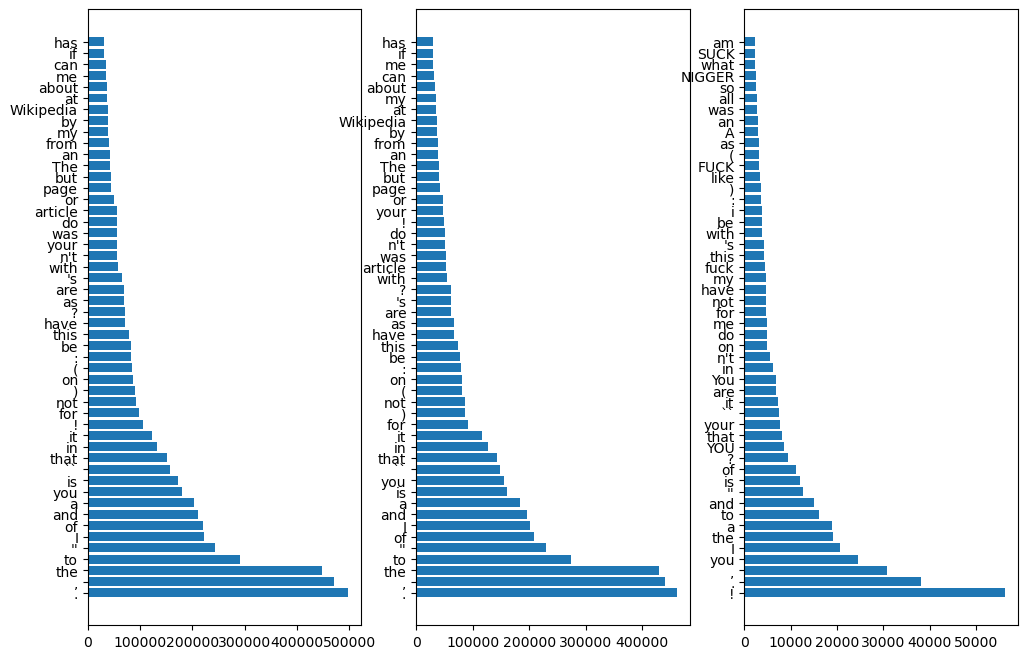

In [537]:
bars([words_w_trash.head(50),words_w_trash0.head(50),words_w_trash1.head(50)])

In [135]:
#bars([words_wo_trash.head(50),words_wo_trash0.head(50),words_wo_trash1.head(50)])

In [136]:
#bars([words_wo.head(50),words_wo0.head(50),words_wo1.head(50)])

for item in [words_wo_trash,words_wo_trash0,words_wo_trash1]:
    display(item[item['Frequency']>1].tail(50))

for item in [words_w_trash,words_w_trash0,words_w_trash1]:
    display(item[item['Frequency']>1].tail(50))

In [538]:
words_w_trash.tail(50)#,words_w_trash0.head(50),words_w_trash1.head(50)])

,Word,Frequency
155878,Thai-Vietnamese,1
155881,post-World-War,1
155918,catacombs,1
155919,'multicultural,1
155920,'celebrating,1
155974,terminalogy,1
155957,unf,1
155959,SPOUTED,1
155960,INTENTIONALLY,1
155961,bunchofgrapes,1


In [539]:
words_w_trash0.tail(50)

,Word,Frequency
146582,soul-damning,1
146583,nation-destroying,1
146586,majoritarian,1
146590,dooms,1
146591,damns,1
146625,==Superscript,1
146627,rDNS,1
146628,RFC1912,1
146686,Fieryangel,1
146675,noze,1


In [649]:
words_w_trash1.iloc[-1050:-1000]

,Word,Frequency
29670,DUMMASSES,1
29650,salves,1
29669,STORIES,1
29668,dummasses,1
29666,nanking,1
29664,admiral,1
29663,CONVENIENT,1
29661,HAVOC,1
29658,textBLOCK,1
29657,sadist,1


In [622]:
df['text'][28491]

"Heraldic translation: help needed \nPlease can you translate a blazon. I drew the coat of arms of Coubron but I don't know how to describe in English the hunting horn on which some elements are of an other colour: the little pipe in which you blow, the lace and the metal ring at the end of the horn. Can you help me, please?"

In [403]:
tokenizer.decode(chunker(df['text'][57666]))

'[CLS] guessing you\'ve heard it... [SEP] [CLS] so i wanna know if you want some birthday - cake - cake - cake - cake - cake - cake - birthday - cake - cake - cake - cake!? [SEP] [CLS] because imma make you my bitch tonight ; ) hehe ( in all honesty, that song is beyond ridik ) • talk 2 me " [SEP]'

In [638]:
df[df['text'].str.contains('Birthday-cake-cake-cake')]

,text,toxic
57666,"""\n\n Guessing you've heard it.... \n\nSo I wanna know if you want some Birthday-cake-cake-cake-cake-cake-cake-Birthday-cake-cake-cake-cake!? Because Imma make you my bitch tonight ;) Hehe (in all honesty, that song is beyond ridik) • Talk2Me """,1


In [ ]:
1/0

In [396]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

In [397]:
tokenizer

BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [146]:
tokenizer.added_tokens_encoder

{'[PAD]': 0, '[UNK]': 100, '[CLS]': 101, '[SEP]': 102, '[MASK]': 103}

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [186]:
def logy(feats, target):
    lr = LogisticRegression(random_state=RANDOM_STATE,max_iter=100000,class_weight='balanced')
    lr.fit(feats, target)
    scores = cross_val_score(lr, feats, target, cv=5, scoring='f1_macro')
    return scores

In [ ]:
1/0

In [409]:
samp = df.sample(n=16000, random_state=RANDOM_STATE)

In [410]:
X_train, X_test, y_train, y_test = train_test_split(
    #samp[['text','orient','relig','family']],
    samp['text'],
    samp['toxic'],
    test_size = 0.5,
    random_state = RANDOM_STATE,
    stratify = samp['toxic'])

In [411]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000,), (8000,), (8000,), (8000,))

sampler = RandomUnderSampler(random_state=RANDOM_STATE)
X_resample, y_resample = sampler.fit_resample(pd.DataFrame(X_train), pd.DataFrame(y_train)) 

X_resample.shape, y_resample.shape

res_df = X_resample.join(y_resample)

res_samp = res_df.sample(n=25000, random_state=RANDOM_STATE)

test_samp = pd.DataFrame(X_test).join(pd.DataFrame(y_test)).sample(n=res_samp.shape[0], random_state=RANDOM_STATE)

res_samp.shape

test_samp.shape

In [412]:
class BertTokenizer(object):

    def __init__(self, text, config, batch_size=1):
        
        self.text = text
        self.batch_size = batch_size
        self.config = config
        #self.model_class ,self.pretrained_weights = (
        #    transformers.BertModel, 'bert-base-uncased')    

        #self.config = 
        #self.model = self.model_class.from_pretrained(self.pretrained_weights, config=self.config)
        self.model = transformers.BertModel.from_pretrained('bert-base-uncased', config=self.config)
    
    def get(self):


        
        tokenized = self.text.swifter.apply(lambda x: chunker(x))
        
        max_len = 0
        
        for tok in tokenized.values:
            if len(tok) > max_len:
                max_len = len(tok)

        padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])
        attention_mask = np.where(padded != 0, 1, 0)
        
        batch_size = self.batch_size
        
        embeddings = []
        
        for i in notebook.tqdm(range(len(padded) // batch_size)):
                batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
                attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
                
                with torch.no_grad():
                    batch_embeddings = self.model(batch, attention_mask=attention_mask_batch)
                
                embeddings.append(batch_embeddings[0][:,0,:].numpy())
    
        features = np.concatenate(embeddings)

        return features

df[df['text'].str.contains('I ass. I ass.')]['text']

tokenizer.decode(chunker(df['text'][4703]))

tokenizer.decode(chunker(df['text'][0]))

tokenizer.decode(chunker('someone needs to remove lott 71. 227. 167. 147'))

In [391]:
cfg_dict = {
  "attention_probs_dropout_prob": 0.1,
  #"classifier_dropout": null,
  "directionality": "bidi",
  #"hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 2e-5,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  #"transformers_version": "4.12.5",
  "type_vocab_size": 2,
  #"use_cache": true,
  "vocab_size": 30522
}
cfg = transformers.BertConfig.from_dict(cfg_dict)

In [389]:
cfg

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 2e-05,
  "max_position_embeddings": 210,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.50.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [414]:
dembs_train = BertTokenizer(text=X_train, config = cfg, batch_size=32).get()

Pandas Apply:   0%|          | 0/8000 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1002 > 512). Running this sequence through the model will result in indexing errors


  0%|          | 0/250 [00:00<?, ?it/s]

In [420]:
logy(dembs_train, y_train.values)#.mean()

array([0.8204023 , 0.78571429, 0.80606443, 0.78931401, 0.78923107])

In [384]:
logy(dembs_train, y_train.values)

array([0.77579667, 0.83732441, 0.80135613, 0.77579667, 0.75926093])

In [367]:
logy(dembs_train, y_train.values)

array([0.77079553, 0.82495897, 0.79125897, 0.76525822, 0.75926093])

In [361]:
logy(dembs_train, y_train.values)

array([0.77079553, 0.82495897, 0.80135613, 0.77579667, 0.75926093])

In [355]:
logy(dembs_train, y_train.values)

array([0.77579667, 0.83732441, 0.80135613, 0.77579667, 0.75926093])

In [418]:
np.array([0.77579667, 0.83732441, 0.80135613, 0.77579667, 0.75926093]).mean()

0.7899069620000001

array([0.48      , 0.45833333, 0.48      , 1.        , 0.45454545])

In [276]:
logy(dembs_train, y_train.values[:64])

array([0.48      , 0.45833333, 0.48      , 1.        , 0.45454545])

In [254]:
logy(dembs_train, y_train.values)#.mean()

array([0.80672127, 0.79560179, 0.7593985 , 0.77117022, 0.72710517])

In [239]:
logy(dembs_train, y_train.values).mean()

0.7264326019343731

In [240]:
np.array([0.7667793 , 0.7667793 , 0.70800255, 0.68852069, 0.70548673]).mean()

0.7271137139999999

In [202]:
logy(dembs_train[:64], y_train.values[:64])

array([0.48      , 0.45833333, 0.48      , 1.        , 0.47826087])

In [234]:
logy(dembs_train[:64], y_train.values[:64])

array([0.45833333, 0.70454545, 0.45833333, 1.        , 0.47826087])

In [233]:
logy(dembs_train, y_train.values)

array([0.7667793 , 0.7667793 , 0.70800255, 0.68852069, 0.70548673])

In [204]:
logy(dembs_train, y_train.values).mean()

0.7819758437341131

In [205]:
X_train.iloc[:64]

7884                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [195]:
logy(dembs_train[:64], y_train.values[:64])

array([0.48      , 0.45833333, 0.48      , 1.        , 0.45454545])

In [194]:
logy(dembs_train, y_train.values)

array([0.76640204, 0.78542536, 0.77142857, 0.78607583, 0.78090767])

In [197]:
logy(dembs_train, y_train.values).mean()

0.778047895210849

In [845]:
logy(dembs_train, y_train.values).mean()

0.8077269600671416

In [ ]:
dembs_test = BertTokenizer(text=X_test, batch_size=32).get()

In [61]:
def f1_eval(y_true, y_pred,):

    f1 = f1_score(y_pred, y_true, average=None)[1]
    return f1

In [62]:
def f1_xgb(y_pred, dtrain):
    y_true = dtrain.get_label()
    f1 = f1_score( y_pred,y_true, average=None)[1]

    return 'f1', f1

In [63]:
from sklearn.metrics import make_scorer
my_func = make_scorer(f1_eval, greater_is_better=True)

In [64]:
pipe = Pipeline([('models',[LogisticRegression(random_state=RANDOM_STATE,class_weight='balanced')])])

In [65]:
p_wei = y_train.value_counts()[0]/y_train.value_counts()[1]

In [66]:
param_grid = [

    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, class_weight='balanced')],
        'models__solver': ['newton-cg', 'liblinear'],
          
    },

    {
        'models': [XGBClassifier(
            random_state=RANDOM_STATE,
            eval_metric='logloss',
            scale_pos_weight = p_wei
            
            )],
        'models__n_estimators':[100, 200, 500],
        'models__max_depth':[3, 4, 5],
        'models__learning_rate':[0.2, 0.1, 0.05],
        'models__reg_alpha':[0.1, 1],
        'models__reg_lambda':[1, 1.5, 2],        
        
        
    }

]

In [67]:
grid_search = GridSearchCV(
    pipe, 
    param_grid, 
    cv=5,
    #scoring='f1',
    scoring=my_func,
    n_jobs=-1
)
grid_search.fit(dembs_train, y_train)
#grid_search.fit(trial, y_train.values)
#grid_search.fit(trial, res_samp['toxic'])
###grid_search.fit(tr.drop('toxic', axis=1), tr['toxic'])

C:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,estimator,Pipeline(step..._state=88)])])
,param_grid,"[{'models': [LogisticRegre...ndom_state=88)], 'models__solver': ['newton-cg', 'liblinear']}, {'models': [XGBClassifier...ree=None, ...)], 'models__learning_rate': [0.2, 0.1, ...], 'models__max_depth': [3, 4, ...], 'models__n_estimators': [100, 200, ...], ...}]"
,scoring,make_scorer(f...hod='predict')
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [ ]:
#n_estimators 	2000, learning_rate 	0.1, max_depth 	5

In [68]:
pd.DataFrame(grid_search.cv_results_)[['rank_test_score', 'mean_test_score','params']].sort_values('rank_test_score').head(15)

,rank_test_score,mean_test_score,params
109,1,0.726700,"{'models': XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, device=None, early_stopping_rounds=None, enable_categorical=False, eval_metric='logloss', feature_types=None, feature_weights=None, gamma=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=None, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, multi_strategy=None, n_estimators=None, n_jobs=None, num_parallel_tree=None, ...), 'models__learning_rate': 0.1, 'models__max_depth': 5, 'models__n_estimators': 500, 'models__reg_alpha': 1, 'models__reg_lambda': 2}"
107,2,0.725524,"{'models': XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, device=None, early_stopping_rounds=None, enable_categorical=False, eval_metric='logloss', feature_types=None, feature_weights=None, gamma=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=None, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, multi_strategy=None, n_estimators=None, n_jobs=None, num_parallel_tree=None, ...), 'models__learning_rate': 0.1, 'models__max_depth': 5, 'models__n_estimators': 500, 'models__reg_alpha': 1, 'models__reg_lambda': 1}"
55,3,0.725432,"{'models': XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, device=None, early_stopping_rounds=None, enable_categorical=False, eval_metric='logloss', feature_types=None, feature_weights=None, gamma=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=None, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, multi_strategy=None, n_estimators=None, n_jobs=None, num_parallel_tree=None, ...), 'models__learning_rate': 0.2, 'models__max_depth': 5, 'models__n_estimators': 500, 'models__reg_alpha': 1, 'models__reg_lambda': 2}"
34,4,0.723578,"{'models': XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, device=None, early_stopping_rounds=None, enable_categorical=False, eval_metric='logloss', feature_types=None, feature_weights=None, gamma=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=None, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, multi_strategy=None, n_estimators=None, n_jobs=None, num_parallel_tree=None, ...), 'models__learning_rate': 0.2, 'models__max_depth': 4, 'models__n_estimators': 500, 'models__reg_alpha': 0.1, 'models__reg_lambda': 2}"
106,5,0.723561,"{'models': XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, device=None, early_stopping_rounds=None, enable_categorical=False, eval_metric='logloss', feature_types=None, feature_weights=None, gamma=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=None, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, multi_strategy=None, n_estimators=None, n_jobs=None, num_parallel_tree=None, ...), 'models__learning_rate': 0.1, 'models__max_depth': 5, 'models__n_estimators': 500, 'models__reg_alpha': 0.1, 'models__reg_lambda': 2}"
36,6,0.723516,"{'models

In [69]:
pd.DataFrame(grid_search.cv_results_)[['rank_test_score', 'mean_test_score','params']].sort_values('rank_test_score')

,rank_test_score,mean_test_score,params
109,1,0.726700,"{'models': XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, device=None, early_stopping_rounds=None, enable_categorical=False, eval_metric='logloss', feature_types=None, feature_weights=None, gamma=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=None, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, multi_strategy=None, n_estimators=None, n_jobs=None, num_parallel_tree=None, ...), 'models__learning_rate': 0.1, 'models__max_depth': 5, 'models__n_estimators': 500, 'models__reg_alpha': 1, 'models__reg_lambda': 2}"
107,2,0.725524,"{'models': XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, device=None, early_stopping_rounds=None, enable_categorical=False, eval_metric='logloss', feature_types=None, feature_weights=None, gamma=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=None, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, multi_strategy=None, n_estimators=None, n_jobs=None, num_parallel_tree=None, ...), 'models__learning_rate': 0.1, 'models__max_depth': 5, 'models__n_estimators': 500, 'models__reg_alpha': 1, 'models__reg_lambda': 1}"
55,3,0.725432,"{'models': XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, device=None, early_stopping_rounds=None, enable_categorical=False, eval_metric='logloss', feature_types=None, feature_weights=None, gamma=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=None, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, multi_strategy=None, n_estimators=None, n_jobs=None, num_parallel_tree=None, ...), 'models__learning_rate': 0.2, 'models__max_depth': 5, 'models__n_estimators': 500, 'models__reg_alpha': 1, 'models__reg_lambda': 2}"
34,4,0.723578,"{'models': XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, device=None, early_stopping_rounds=None, enable_categorical=False, eval_metric='logloss', feature_types=None, feature_weights=None, gamma=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=None, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, multi_strategy=None, n_estimators=None, n_jobs=None, num_parallel_tree=None, ...), 'models__learning_rate': 0.2, 'models__max_depth': 4, 'models__n_estimators': 500, 'models__reg_alpha': 0.1, 'models__reg_lambda': 2}"
106,5,0.723561,"{'models': XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, device=None, early_stopping_rounds=None, enable_categorical=False, eval_metric='logloss', feature_types=None, feature_weights=None, gamma=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=None, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, multi_strategy=None, n_estimators=None, n_jobs=None, num_parallel_tree=None, ...), 'models__learning_rate': 0.1, 'models__max_depth': 5, 'models__n_estimators': 500, 'models__reg_alpha': 0.1, 'models__reg_lambda': 2}"
...,...,...,...
110,160

In [706]:
#grid_pred = grid_search.best_estimator_.predict(debs_no_dups_test.drop('toxic', axis=1))

In [79]:
#grid_pred = grid_search.best_estimator_.predict(trial_trial)
grid_pred = grid_search.best_estimator_.predict(dembs_test)

In [71]:
df[df['text'].str.contains('Wikipedia')].sample()

,text,toxic
17396,"Adviretisement on Wikipedia =\n\nHey Jimbo, I'm here to recommend an ad style. We need money to keep up the good work. Donations may not hold it still. We can't risk Wikipedia. So, instead of ad spots and annoying popups, we can take sponsors for external links. There are aready thousands of ad style links. Why not add one to links and support the encyclopedia. For example, game articles, they'd be an opportunity. Links like a Steam link will be enlightening too. You can count all commercial and information providing sites.",0


In [843]:
clean_sents("\n\nImage:Club_Comunicaciones.gif\nI have tagged Image:Club_Comunicaciones.gif as , b")

['XXF XXF', 'I have tagged XXF XXF as , b']

In [73]:
re.sub(r'Wikipedia.*:\S+',' XXWIKI ',df['text'][80769])

'And what do you mean by deragatory comments? I think France itself is beautiful! And the people are sweetie-pies! There was no deragatorism anywhere. And I am for improving Wikipedia. Are you?'

In [74]:
f1_score(grid_pred, y_test,average=None)

array([0.96988912, 0.72324841])

In [213]:
print(classification_report(grid_pred, y_test))
#print(classification_report(grid_pred, test_samp['toxic']))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     14406
           1       0.71      0.73      0.72      1594

    accuracy                           0.94     16000
   macro avg       0.84      0.85      0.84     16000
weighted avg       0.94      0.94      0.94     16000



In [ ]:
pd.DataFrame(dembs_train).du

In [75]:


classifier_tuned_threshold = TunedThresholdClassifierCV(
    grid_search.best_estimator_, scoring=my_func, n_jobs=-1
).fit(dembs_train, y_train)


In [76]:
ctt_pred = classifier_tuned_threshold.predict(dembs_test)

In [77]:
classifier_tuned_threshold.best_threshold_

0.40404059928799263

In [78]:
f1_score(y_test, ctt_pred)

0.723963908854565

In [226]:
classifier_other_threshold = FixedThresholdClassifier(
    grid_search.best_estimator_, threshold=0.9, response_method="predict_proba"
).fit(dembs_train, y_train)

cot_pred = classifier_other_threshold.predict(dembs_test)

f1_score(y_test, cot_pred)

0.6962962962962963

In [698]:
f1_score(y_test, cot_pred, average=None)

array([0.96813811, 0.71620227])

In [ ]:
classifier_other_threshold = FixedThresholdClassifier(
    grid_search.best_estimator_, threshold=0.6, response_method="predict_proba"
).fit(debs_no_dups.drop('toxic', axis=1), debs_no_dups['toxic'])
f1_score(debs_no_dups_test['toxic'], classifier_other_threshold.predict(debs_no_dups_test.drop('toxic', axis=1)))#,average=None)#82

In [235]:
res =pd.DataFrame({'a':grid_pred, 'b':y_test})

In [236]:
ind_res = res[(res['b']==1) & (res['b']!=res['a'])]

In [237]:
ind_res

,a,b
107201,0,1
99887,0,1
49033,0,1
104459,0,1
151857,0,1
...,...,...
124215,0,1
13969,0,1
127851,0,1
36397,0,1


In [113]:
#bullsh*t

In [242]:
df[df.index.isin(ind_res.index)].sample(5)

,Unnamed: 0,text,toxic
20118,20138,"Ask me if I care, second-hander.",1
105236,105333,"To the psycho calling himself Majeston, who has no respect for the real name and meaning of this title, and hence is a genetic loser. We have viewed your postings and have found you to be unfamiliar and a failure at your understanding of the true ongoings of the Urantia movement. The facts are that the Urantia Readers-Intl is a large, fast moving, and growing organization that stayed with the original Midwayer mandates and the 1950 Doctorine of Trust - that is one reason why we grabbed the torch of the Urantia Brotherhood and still hold it in true light. \n\nThe slow failure of the Urantia Book Fellowship has caused many of their misguided believers to join the Urantia Association International and the Urantia Readers-Intl... and these are the inside facts, which you are not a privy to. So, little man, here are the facts once again reinstated, for your reality.... if you delete us, we delete you (Fellowship); if you put the Urantia Book Fellowship link back in, and keep ours in, the we keep yours in; if you place the Urantia Book Fellowship link above us, we will place our link above you... you want a war, you got it.",1
119838,119943,"Choose your Loyalties \n\nSir,\n\nIt has come to my attention that despite taking advantage of our first-rate American education facilities, you insist upon identifying as a Bangladeshi.\n\nMy parents are/were Bangladeshis, and they were amongst the most wretched people I have ever had the misfortune of knowing; Indeed, during this unfortunate period of my life that I have been forced to spend in Bangladesh due to my father, I am now convinced that Bangladesh is the single most unworthy nation to exist. (I use are/were because, I regret to say, my mother was struck dead by Bangladesh - and despite her dysfunctional state and pathological lying, I mourn her loss greatly.)\n\nNever have I felt more love for my country than now, when I find myself forced away from it! I have now given my loyalty, heart and soul, to the United States of America: The greatest country in the world, God bless every inch of it.\n\nBut after my experiences with Bangladeshis, I cannot allow for one such as yourself to leech off of the United States while offering nothing in return. I implore you to either renounce Bangladesh and enjoy the remainder of your life in the blessed free world, or get the fuck out of my country, you filthy ape.\n\nSincerely yours,\n\nA proud AMERICAN",1
133613,133751,"Removed the statement. It would be obvious from the specifics I mentioned that I have read the article. So in response to your blatant insult, fuck you too.",1
101459,101556,"Thanks. And who is the motherfucker who nominated it for deletion? Well, let me guess...",1


In [128]:
tokenizer.decode(chunker(df['text'][84379]))

"[CLS] cesc fabregas [SEP] [CLS] you're a fucking idiot. [SEP] [CLS] cesc fabregas signed for chelsea today you moron. [SEP] [CLS] it's been confirmed by both barcelona and chelsea. [SEP] [CLS] the transfer window for england opened on june 10 th, not july 1 st, get your facts straight. [SEP] [CLS] there's even pictures of him holding a chelsea jersey. [SEP] [CLS] get your facts right, fabregas is officially a chelsea player now you fucking retard. [SEP]"

In [152]:
res[(res['a']==1) & (res['b']!=res['a'])].to_excel('wrong.xlsx')

In [ ]:
pd.DataFrame(dembs_train).duplicated().sum()

In [ ]:
f1_score(y_test, classifier_other_threshold.predict(dembs_test))#82

In [ ]:
cl_preds_adj = classifier_tuned.predict(dembs_val)

In [ ]:
f1_score(cl_preds_adj,y_val)

In [ ]:
res =pd.DataFrame({'a':grid_pred, 'b':test_sample['toxic']})

In [ ]:
pd.DataFrame(probs[0])

In [ ]:
y_test.shape

In [ ]:
pd.DataFrame({'proba':list(probs[1])},
              {'predicted':grid_pred})

In [ ]:
probs_res = pd.DataFrame(zip(y_test,probs[1],grid_pred),columns=['toxic', 'proba', 'pred'])

In [ ]:
probs_res[(probs_res['toxic']!=probs_res['pred']&(probs_res['toxic']==1))]['proba']

In [ ]:
X_test.iloc[1961]

In [ ]:
X_train.apply(lambda x: len(x)).hist()

In [ ]:
X_train.shape

In [ ]:
X_resample.shape

In [ ]:
X_train[X_train.apply(lambda x: len(x))>2000]

In [ ]:
res.shape

In [ ]:
df['text'].

In [ ]:
df[(df.index.isin(res[res['a']!=res['b']].index))&(df['toxic']==1)]['text'].apply(lambda x: tokenizer.decode(chunker(x)))#.sample()



#['b'].value_counts()

In [ ]:
tokenizer.decode(chunker(df.loc[128933]['text']))

In [ ]:
df.loc[128933]['text']

## Обучение

In [ ]:
#from phik.report import plot_correlation_matrix
#from phik import phik_matrix

In [ ]:
#df.info()

phik_overview = phik_matrix(df[['toxic','word_count']],verbose=False)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Blues',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(18, 14)
) 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df['text_lemm'], 
    df['toxic'], 
    random_state=RANDOM_STATE,
    stratify=df['toxic']
)

In [ ]:
sampler = RandomUnderSampler(random_state=RANDOM_STATE)
X_resample, y_resample = sampler.fit_resample(pd.DataFrame(X_train), pd.DataFrame(y_train)) 


In [ ]:
y_resample.value_counts()

In [ ]:
pd.DataFrame(y_test).value_counts()

## Выводы

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Модели обучены
- [ ]  Значение метрики *F1* не меньше 0.75
- [ ]  Выводы написаны